# Imports 

In [56]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.max_rows', None)     
pd.set_option('display.float_format', '{:.4f}'.format)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

In [57]:
player_stats = pd.read_csv('../data/player_stats.csv')
match_events = pd.read_csv('../data/match_event_base.csv')
shots_events = pd.read_csv('../data/shot_events.csv')
card_events = pd.read_csv('../data/card_events.csv')
match_stats = pd.read_csv('../data/norm_matches.csv')
rounds = pd.read_csv('../data/matches.csv')
players = pd.read_csv('../data/players.csv', encoding='utf-8')
seasons = pd.read_csv('../data/seasons.csv')


In [58]:
player_stats.head()

,player_match_stat_id,match_id,player_id,team_id,is_substitute,played_position,jersey_number,market_value_eur_at_match,sofascore_rating,minutes_played,touches,goals,assists,own_goals,passes_accurate,passes_total,passes_key,long_balls_accurate,long_balls_total,crosses_accurate,crosses_total,shots_total,shots_on_target,shots_off_target,shots_blocked_by_opponent,dribbles_successful,dribbles_attempts,possession_lost,dispossessed,duels_won,duels_lost,aerials_won,aerials_lost,ground_duels_won,ground_duels_total,tackles,interceptions,clearances,shots_blocked_by_player,dribbled_past,fouls_committed,fouls_suffered,saves,punches_made,high_claims,saves_inside_box,sweeper_keeper_successful,sweeper_keeper_total,goals_prevented,runs_out_successful,penalties_saved,penalty_committed,expected_goals,expected_assists,penalty_won,penalty_miss,big_chances_missed,errors_leading_to_shot,big_chances_created,errors_leading_to_goal
0,1,11352250,84844,60,f,G,1,1900000.0000,6.4000,90,46,0,0,0,27,39,0,6,18,0,0,0,0,0,0,0,0,12,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-0.2972,0,0,0,0.0000,0.0053,0,0,0,0,0,0
1,2,11352250,943645,60,f,D,37,11600000.0000,6.9000,75,52,0,0,0,32,36,1,1,1,0,1,0,0,0,0,0,0,6,0,6,6,0,3,0,3,2,0,0,0,1,1,2,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0691,0,0,0,0,0,0
2,3,11352250,1023567,60,f,D,27,37000000.0000,6.5000,90,102,0,0,0,77,96,0,4,15,0,0,0,0,0,0,0,0,20,0,5,8,4,5,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0122,0,0,0,0,0,0
3,4,11352250,830659,60,f,D,25,22000000.0000,6.7000,60,62,0,0,0,43,51,0,3,8,0,0,0,0,0,0,0,0,10,1,3,6,1,2,2,0,2,1,3,1,2,1,0,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0172,0,0,0,0,0,0
4,5,11352250,1097425,60,f,D,3,36000000.0000,6.8000,90,75,0,0,0,31,40,1,2,3,1,4,0,0,0,0,0,0,17,1,10,6,4,2,6,3,2,0,3,0,1,0,3,0,0,0,0,0,0,NaN,0,0,0,0.0000,0.0493,0,0,0,0,0,0


As we can see Theres tons of players without a rating. We will only work with players that participate in the game, in this case we will be dropping those with Nulls rating

Now lets check the data of the games overall. We will be looking at the stats on the full game.

# Filtering for only full time stats

In [59]:
match_stats_full = match_stats.loc[match_stats['period'] == 'ALL']
print(len(match_stats_full))

7378


In [60]:
match_stats_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7378 entries, 0 to 22129
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   team_match_stat_id           7378 non-null   int64  
 1   match_id                     7378 non-null   int64  
 2   team_id                      7378 non-null   int64  
 3   opp_team_id                  7378 non-null   int64  
 4   home_away                    7378 non-null   object 
 5   period                       7378 non-null   object 
 6   formation                    7376 non-null   object 
 7   average_team_rating          7376 non-null   float64
 8   total_team_market_value_eur  7376 non-null   float64
 9   possession_percentage        7378 non-null   float64
 10  big_chances                  7378 non-null   int64  
 11  total_shots                  7378 non-null   int64  
 12  saves                        7378 non-null   int64  
 13  corners               

# Events: Cards + Shots

In [61]:
match_events.head()

,event_id,match_id,minute,event_type,team_id,player_id
0,1,11352250,90,card,60,865740.0000
1,2,11352250,90,substitution,37,839981.0000
2,3,11352250,90,card,37,839981.0000
3,4,11352250,87,card,37,155997.0000
4,5,11352250,86,substitution,37,816763.0000


In [62]:
shots_events.head()

,event_id,shooter_player_id,shot_outcome,situation,body_part,xg,xgot,player_coord_x,player_coord_y,goal_mouth_location,goal_mouth_coord_x,goal_mouth_coord_y,goal_mouth_coord_z,block_coord_x,block_coord_y,goalkeeper_id,added_time
0,16,934354,block,assisted,left-foot,0.0193,NaN,27.5000,57.3000,low-centre,0,50.4000,19.0000,17.0000,54.3000,NaN,NaN
1,17,839981,post,regular,left-foot,0.0642,NaN,13.5000,36.0000,left,0,55.2000,6.3000,NaN,NaN,NaN,NaN
2,18,130181,block,assisted,right-foot,0.1237,NaN,12.0000,64.5000,low-right,0,48.0000,19.0000,7.6000,59.9000,NaN,NaN
3,19,361420,goal,regular,right-foot,0.8712,0.9686,3.5000,54.9000,low-right,0,47.7000,2.5000,NaN,NaN,NaN,NaN
4,20,934354,miss,regular,right-foot,0.0543,NaN,21.7000,62.9000,left,0,66.7000,15.3000,14.2000,52.3000,NaN,NaN


In [63]:
card_events.head()

,event_id,card_type,reason,is_rescinded
0,1,yellow,Argument,f
1,3,yellow,Persistent fouling,f
2,4,yellow,Foul,f
3,14,yellow,Foul,f
4,15,yellow,Argument,f


In [64]:
only_shots_events = match_events.loc[(match_events['event_type'] == 'shot')]

#Goals are presented in shot events also...
shot_events_per_match = pd.merge(only_shots_events, shots_events, on='event_id', how = 'left')
shot_events_per_match.head()

,event_id,match_id,minute,event_type,team_id,player_id,shooter_player_id,shot_outcome,situation,body_part,xg,xgot,player_coord_x,player_coord_y,goal_mouth_location,goal_mouth_coord_x,goal_mouth_coord_y,goal_mouth_coord_z,block_coord_x,block_coord_y,goalkeeper_id,added_time
0,16,11352250,89,shot,60,934354.0000,934354,block,assisted,left-foot,0.0193,NaN,27.5000,57.3000,low-centre,0,50.4000,19.0000,17.0000,54.3000,NaN,NaN
1,17,11352250,85,shot,37,839981.0000,839981,post,regular,left-foot,0.0642,NaN,13.5000,36.0000,left,0,55.2000,6.3000,NaN,NaN,NaN,NaN
2,18,11352250,84,shot,37,130181.0000,130181,block,assisted,right-foot,0.1237,NaN,12.0000,64.5000,low-right,0,48.0000,19.0000,7.6000,59.9000,NaN,NaN
3,19,11352250,82,shot,60,361420.0000,361420,goal,regular,right-foot,0.8712,0.9686,3.5000,54.9000,low-right,0,47.7000,2.5000,NaN,NaN,NaN,NaN
4,20,11352250,82,shot,60,934354.0000,934354,miss,regular,right-foot,0.0543,NaN,21.7000,62.9000,left,0,66.7000,15.3000,14.2000,52.3000,NaN,NaN


Now the interesting thing will be to find how many shots where inside the area on target, by looking at the shot distance and outcome given by (player_coord_x and shot_outcome(goal or saved)) in every match. We will use these stats to evaluate about 80% the performance of the goalkeeper.



In [65]:
#corner goals
goals_due_to_corner = shot_events_per_match[
    (shot_events_per_match['situation'] == 'corner') & (shot_events_per_match['shot_outcome'] == 'goal')
]
goals_due_to_corner_per_game = goals_due_to_corner.groupby(['match_id', 'team_id']).size().reset_index(name = 'goals_due_to_corner')

# Mapping the field + the shots

The idea is to define a limited area, based on rectangles to map every shot. Then with all the data we will learn how many goals there are in every sector. After that we will stablish how likely its a goal there, how important is a save or a block. Lastly we will use this metrics to quantify the performance of a player depending on its position.

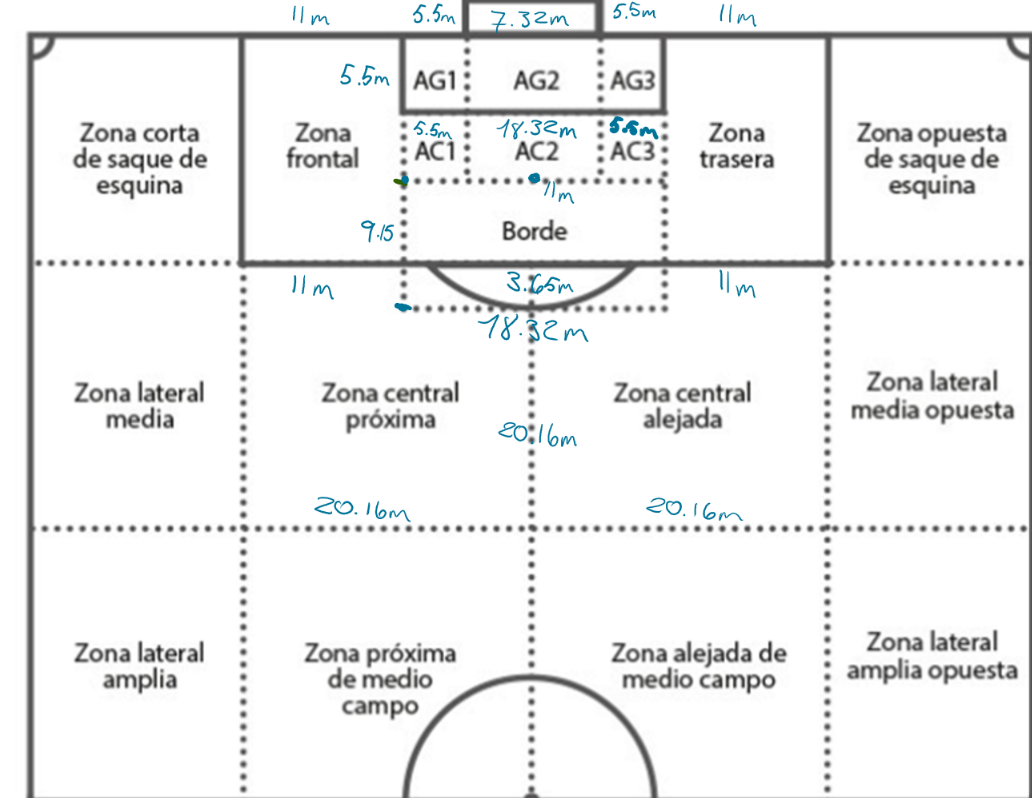


In [66]:
def map_shot_to_area(df):

    
    X_LINEA_FONDO = 0.0
    X_LINEA_GK_AREA = 5.5
    X_TOPE_PUNTO_PENAL = 11
    X_TOPE_AREA_GRANDE = 16.5
    X_TOPE_SEMI_LUNA = 20.15
    X_TOPE_ZCP = 36.66 #Lim of Zona Central Proxima and Zona Central Alejada


    Y_PENALTY_POINT = 50

    Y_LIM_L_AG2 = Y_PENALTY_POINT - 3.66
    Y_LIM_L_AG1 = Y_LIM_L_AG2 - 5.5
    Y_LIM_AREA_GRANDE_L = Y_LIM_L_AG1 - 11
    LIM_FIELD_L = 0

    
    Y_LIM_R_AG2 = Y_PENALTY_POINT + 3.66
    Y_LIM_R_AC3 = Y_LIM_R_AG2 + 5.5
    Y_LIM_AREA_GRANDE_R = Y_LIM_R_AC3 + 11
    LIM_FIELD_R = 100

    x = df['player_coord_x']
    y = df['player_coord_y']

    #========================================================================================
    conditions = []
    values = []

    #Zona corte de esquina
    mask_zona_corta_esquina_L = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y < Y_LIM_AREA_GRANDE_L)
    conditions.append(mask_zona_corta_esquina_L)
    values.append('FL1')

    #Zona frontal area
    mask_zona_frontal = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y >= Y_LIM_AREA_GRANDE_L) & (y < Y_LIM_L_AG1)
    conditions.append(mask_zona_frontal)
    values.append('FL2')

    mask_x1 = (x >= X_LINEA_FONDO) & (x < X_LINEA_GK_AREA)
    conditions.append(mask_x1 & (y >= Y_LIM_L_AG1) & (y <  Y_LIM_L_AG2))
    values.append('AG1')
    conditions.append(mask_x1 & (y >= Y_LIM_L_AG2) & (y <=  Y_LIM_R_AG2))
    values.append('AG2')
    conditions.append(mask_x1 & (y > Y_LIM_R_AG2) & (y <= Y_LIM_R_AC3))
    values.append('AG3')

    mask_x2 = (x >= X_LINEA_GK_AREA) & (x < X_TOPE_PUNTO_PENAL)
    conditions.append(mask_x2 & (y >= Y_LIM_L_AG1) & (y <  Y_LIM_L_AG2))
    values.append('AC1')
    conditions.append(mask_x2 & (y >= Y_LIM_L_AG2) & (y <=  Y_LIM_R_AG2))
    values.append('AC2')
    conditions.append(mask_x2 & (y > Y_LIM_R_AG2) & (y <= Y_LIM_R_AC3))
    values.append('AC3')

    mask_zona_trasera = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y > Y_LIM_R_AC3) & (y <= Y_LIM_AREA_GRANDE_R)
    conditions.append(mask_zona_trasera)
    values.append('FL3')


    mask_zona_corta_esquina_R = (x >= X_LINEA_FONDO) & (x < X_TOPE_AREA_GRANDE) & (y > Y_LIM_AREA_GRANDE_R) 
    conditions.append(mask_zona_corta_esquina_R)
    values.append('FL4')

    mask_x4 = (x >= X_TOPE_PUNTO_PENAL) & (x < X_TOPE_AREA_GRANDE) & (y > Y_LIM_L_AG1) & (y < Y_LIM_R_AC3) & (df['situation'] != 'penalty')
    conditions.append(mask_x4)
    values.append('B1')

    #====================================================================================================================
    mask_xx5 = (x >= X_TOPE_AREA_GRANDE) & (x < X_TOPE_SEMI_LUNA) & (y >= Y_LIM_AREA_GRANDE_L) & (y <= Y_PENALTY_POINT)
    mask_xxx5 = (x >= X_TOPE_AREA_GRANDE) & (x < X_TOPE_SEMI_LUNA) & (y > Y_PENALTY_POINT) & (y <= Y_LIM_AREA_GRANDE_R)
    conditions.append(mask_xx5)
    values.append('B2') 
    conditions.append(mask_xxx5)
    values.append('B3')


    #=====================================================================================================================
    mask_x5 = (x >= X_TOPE_SEMI_LUNA) & (x < X_TOPE_ZCP)
    conditions.append(mask_x5 & (y >= 0) & (y <= Y_LIM_AREA_GRANDE_L))
    values.append('YF1')
    conditions.append(mask_x5 & (y >  Y_LIM_AREA_GRANDE_L) & (y <  Y_PENALTY_POINT))
    values.append('YF2')
    conditions.append(mask_x5 & (y >= Y_PENALTY_POINT)   & (y <=  Y_LIM_AREA_GRANDE_R))
    values.append('YF3')
    conditions.append(mask_x5 & (y > Y_LIM_AREA_GRANDE_R) & (y <= 100))
    values.append('YF4')

    mask_x6 = x >= X_TOPE_ZCP
    conditions.append(mask_x6 & (y >= 0)                & (y <= Y_LIM_AREA_GRANDE_L))
    values.append('ZF1')
    conditions.append(mask_x6 & (y >  Y_LIM_AREA_GRANDE_L) & (y <  Y_PENALTY_POINT))
    values.append('ZF2')
    conditions.append(mask_x6 & (y >= Y_PENALTY_POINT) & (y <  Y_LIM_AREA_GRANDE_R))
    values.append('ZF3')
    conditions.append(mask_x6 & (y >= Y_LIM_AREA_GRANDE_R))
    values.append('ZF4')

    conditions.append(df['situation'] == 'penalty')
    values.append('penalty')

    df['shot_zone'] = np.select(conditions, values, default='sin_zona')

    df = df[df['shot_zone'] != 'penalty']

    return df



shots_events_per_match_mapped = map_shot_to_area(shot_events_per_match)
shots_events_per_match_mapped.head()
#print(shots_events_per_match_mapped['shot_zone'].value_counts())

,event_id,match_id,minute,event_type,team_id,player_id,shooter_player_id,shot_outcome,situation,body_part,xg,xgot,player_coord_x,player_coord_y,goal_mouth_location,goal_mouth_coord_x,goal_mouth_coord_y,goal_mouth_coord_z,block_coord_x,block_coord_y,goalkeeper_id,added_time,shot_zone
0,16,11352250,89,shot,60,934354.0000,934354,block,assisted,left-foot,0.0193,NaN,27.5000,57.3000,low-centre,0,50.4000,19.0000,17.0000,54.3000,NaN,NaN,YF3
1,17,11352250,85,shot,37,839981.0000,839981,post,regular,left-foot,0.0642,NaN,13.5000,36.0000,left,0,55.2000,6.3000,NaN,NaN,NaN,NaN,FL2
2,18,11352250,84,shot,37,130181.0000,130181,block,assisted,right-foot,0.1237,NaN,12.0000,64.5000,low-right,0,48.0000,19.0000,7.6000,59.9000,NaN,NaN,FL3
3,19,11352250,82,shot,60,361420.0000,361420,goal,regular,right-foot,0.8712,0.9686,3.5000,54.9000,low-right,0,47.7000,2.5000,NaN,NaN,NaN,NaN,AG3
4,20,11352250,82,shot,60,934354.0000,934354,miss,regular,right-foot,0.0543,NaN,21.7000,62.9000,left,0,66.7000,15.3000,14.2000,52.3000,NaN,NaN,YF3


In [67]:
#Lets do some aggregations in order to investigate the efficiency of the shots made.
matches_with_shots = shots_events_per_match_mapped.groupby(['match_id', 'event_type']).count().reset_index()

shots_converted_goal = shots_events_per_match_mapped[
    shots_events_per_match_mapped['shot_outcome'] == 'goal'
]
shots_saved = shots_events_per_match_mapped[
    shots_events_per_match_mapped['shot_outcome'] == 'save'
]

shots_blocked = shots_events_per_match_mapped[
    shots_events_per_match_mapped['shot_outcome'] == 'block'
]

shots_on_target = shots_events_per_match_mapped[(
    shots_events_per_match_mapped['shot_outcome'] == 'goal') |
    (shots_events_per_match_mapped['shot_outcome'] == 'save')
]


shots_per_zone = shots_events_per_match_mapped.groupby('shot_zone').size().reset_index(name = 'shots_per_zone')
goals_per_zone = shots_converted_goal.groupby('shot_zone').size().reset_index(name = 'goals_per_zone')
saves_per_zone = shots_saved.groupby('shot_zone').size().reset_index(name = 'shots_saves_per_zone')
blocks_per_zone = shots_blocked.groupby('shot_zone').size().reset_index(name = 'shots_blocked_per_zone')
shot_on_target_per_zone = shots_on_target.groupby('shot_zone').size().reset_index(name = 'shots_on_target_per_zone')


area_stats = pd.DataFrame()
area_stats['shot_zone'] = shots_per_zone['shot_zone']
area_stats['shots_per_zone'] = shots_per_zone['shots_per_zone']
area_stats['goals_per_zone'] = goals_per_zone['goals_per_zone']
area_stats['ratio_goals_shot_per_zone'] = area_stats['goals_per_zone'] / area_stats['shots_per_zone']
total_goals = area_stats['goals_per_zone'].sum()
area_stats['ratio_goals_zone'] = area_stats['goals_per_zone'] / total_goals
area_stats['shots_saves_per_zone'] = saves_per_zone['shots_saves_per_zone']
area_stats['blocks_per_zone'] = blocks_per_zone['shots_blocked_per_zone']

area_stats['ratio_saves'] = area_stats['shots_saves_per_zone'] / area_stats['shots_per_zone']
area_stats['ratio_blocks'] = area_stats['blocks_per_zone'] / area_stats['shots_per_zone']
area_stats['shots_on_target_per_zone'] = shot_on_target_per_zone['shots_on_target_per_zone']

area_stats['ratio_goal_shot_on_t_per_zone'] = area_stats['goals_per_zone'] / area_stats['shots_on_target_per_zone']
area_stats


,shot_zone,shots_per_zone,goals_per_zone,ratio_goals_shot_per_zone,ratio_goals_zone,shots_saves_per_zone,blocks_per_zone,ratio_saves,ratio_blocks,shots_on_target_per_zone,ratio_goal_shot_on_t_per_zone
0,AC1,4150,610,0.1470,0.0665,924,719,0.2227,0.1733,1534,0.3977
1,AC2,7510,1403,0.1868,0.1530,1586,1071,0.2112,0.1426,2989,0.4694
2,AC3,4012,621,0.1548,0.0677,812,736,0.2024,0.1834,1433,0.4334
3,AG1,1709,442,0.2586,0.0482,315,216,0.1843,0.1264,757,0.5839
4,AG2,2494,1242,0.4980,0.1354,388,220,0.1556,0.0882,1630,0.7620
5,AG3,1519,367,0.2416,0.0400,322,213,0.2120,0.1402,689,0.5327
6,B1,10538,1240,0.1177,0.1352,2355,3092,0.2235,0.2934,3595,0.3449
7,B2,4077,255,0.0625,0.0278,896,1485,0.2198,0.3642,1151,0.2215
8,B3,3980,280,0.0704,0.0305,803,1523,0.2018,0.3827,1083,0.2585
9,FL1,2461,63,0.0256,0.0069,763,753,0.3100,0.3060,826,0.0763


# Calculating goalkeeper performance
Now we will be calculating the performance of the goalkeeper in the match. To be able to do this calculation its important to following these steps.
I. Separating match_stats_full for home_teams and visit_teams, this is due to the fact that the performance of a goalkeeper is based on the shot quality of enemy team.
II. We will group every shot by match & team to calculate the measure for each game individually
III. We will only take on account shots on target since we are evaluating the keeper performance and difficulty of the shots






In [68]:
shots_on_target_only = shots_events_per_match_mapped[
    (shots_events_per_match_mapped['shot_outcome'] == 'goal') | (shots_events_per_match_mapped['shot_outcome'] == 'save')
]


shots_on_target_only['was_goal'] = (shots_on_target_only['shot_outcome'] == 'goal').astype(int)

shots_on_target_only = shots_on_target_only.merge(
    area_stats[['shot_zone', 'ratio_goal_shot_on_t_per_zone']],
    on='shot_zone', how='left'
)

shots_on_target_only['performance_gk'] = (
    shots_on_target_only['ratio_goal_shot_on_t_per_zone'] - shots_on_target_only['was_goal']
)

performance_summary = (
    shots_on_target_only
    .groupby(['match_id', 'team_id'])
    .agg(
        performance_gk = ('performance_gk', 'sum'),
        num_shots_on_target=('performance_gk', 'count')
    )
    .reset_index()
    .rename(columns={'team_id': 'opp_team_id'})
)

performance_summary['avg_performance_gk_per_shot'] = performance_summary['performance_gk'] / performance_summary['num_shots_on_target']
local_stats = match_stats_full[match_stats_full['home_away'] == 'H'].copy()
visit_stats = match_stats_full[match_stats_full['home_away'] == 'A'].copy()


local_stats = local_stats.merge(
    performance_summary,
    on=['match_id', 'opp_team_id'],
    how='left'
)
visit_stats = visit_stats.merge(
    performance_summary,
    on=['match_id', 'opp_team_id'],
    how='left'
)

full_stats_with_perf = pd.concat([local_stats, visit_stats], ignore_index=True)

C:\Users\javie\AppData\Local\Temp\ipykernel_10560\2219023103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_on_target_only['was_goal'] = (shots_on_target_only['shot_outcome'] == 'goal').astype(int)


in the previous script we created two metrics. The idea of the second one is to protect the ratings of good keepers when they dominate a game, we do so by taking the average of the strength of each shot, so if the keeper saves only to shots but both were super dangerous, he will get a good score in the second but not so great one on the first. Basically in one we prioritaze quantity and in the other quality of the saves.

# Cards as a penalty for performance

In [69]:
only_card_events = match_events.loc[match_events['event_type'] == 'card']
card_events_per_match = pd.merge(only_card_events, card_events, on='event_id', how='left')
card_events_per_match.head()


,event_id,match_id,minute,event_type,team_id,player_id,card_type,reason,is_rescinded
0,1,11352250,90,card,60,865740.0000,yellow,Argument,f
1,3,11352250,90,card,37,839981.0000,yellow,Persistent fouling,f
2,4,11352250,87,card,37,155997.0000,yellow,Foul,f
3,14,11352250,49,card,37,47772.0000,yellow,Foul,f
4,15,11352250,39,card,37,552884.0000,yellow,Argument,f


In [70]:
yellow_cards = card_events_per_match[
    card_events_per_match['card_type'] == 'yellow'
]

red_cards = card_events_per_match[
    card_events_per_match['card_type'] == 'red'
]
yellow_cards_for_player_each_game = yellow_cards.groupby(['match_id', 'player_id']).size().reset_index(name = 'yellow_cards_count')
red_cards_for_player_each_game = red_cards.groupby(['match_id', 'player_id']).size().reset_index(name = 'red_cards_count')

player_stats['yellow_cards'] = yellow_cards_for_player_each_game['yellow_cards_count']
player_stats['red_cards'] = red_cards_for_player_each_game['red_cards_count']


In [71]:
player_stats_filled = player_stats.fillna(0)
player_stats_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154277 entries, 0 to 154276
Data columns (total 62 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   player_match_stat_id       154277 non-null  int64  
 1   match_id                   154277 non-null  int64  
 2   player_id                  154277 non-null  int64  
 3   team_id                    154277 non-null  int64  
 4   is_substitute              154277 non-null  object 
 5   played_position            154277 non-null  object 
 6   jersey_number              154277 non-null  int64  
 7   market_value_eur_at_match  154277 non-null  float64
 8   sofascore_rating           154277 non-null  float64
 9   minutes_played             154277 non-null  int64  
 10  touches                    154277 non-null  int64  
 11  goals                      154277 non-null  int64  
 12  assists                    154277 non-null  int64  
 13  own_goals                  15

# Creating the df subset focused on Goalkeepers

In this step we will create the dataset we will use to quantify the performance of a goalkeeper, well do this by filtering by position, mergging the cards & events tables and filling missing values for each player.

In [72]:
goalkeepers = player_stats.loc[player_stats['played_position'] == 'G']


In [73]:
mask = goalkeepers['sofascore_rating'].isna()
goalkeepers = goalkeepers.loc[~mask]
print(len(goalkeepers))
goalkeepers_filled = goalkeepers.fillna(0)
goalkeepers_filled.info()

7462
<class 'pandas.core.frame.DataFrame'>
Index: 7462 entries, 0 to 154235
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_match_stat_id       7462 non-null   int64  
 1   match_id                   7462 non-null   int64  
 2   player_id                  7462 non-null   int64  
 3   team_id                    7462 non-null   int64  
 4   is_substitute              7462 non-null   object 
 5   played_position            7462 non-null   object 
 6   jersey_number              7462 non-null   int64  
 7   market_value_eur_at_match  7462 non-null   float64
 8   sofascore_rating           7462 non-null   float64
 9   minutes_played             7462 non-null   int64  
 10  touches                    7462 non-null   int64  
 11  goals                      7462 non-null   int64  
 12  assists                    7462 non-null   int64  
 13  own_goals                  7462 non-null   int

Now we will separate locals from visitors in order to join the performances based on the rivals team shots. then concanate back together.

In [74]:
rounds = rounds.drop(['round_number', 'match_datetime_utc'], axis = 1)
goalkeepers_with_match = goalkeepers_filled.merge(rounds, on='match_id', how='left')
local_keepers = goalkeepers_with_match[goalkeepers_with_match['team_id'] == goalkeepers_with_match['home_team_id']]
visit_keepers = goalkeepers_with_match[goalkeepers_with_match['team_id'] == goalkeepers_with_match['away_team_id']]
#local_goalkeepers.info()

In [75]:
local_goalkeepers = pd.merge(local_keepers, full_stats_with_perf[['match_id', 'performance_gk', 'season_id', 'round_number', 'match_datetime_utc', 'team_id', 'avg_performance_gk_per_shot']], how='left', on= ['match_id', 'team_id'])
visit_goalkeepers = pd.merge(visit_keepers, full_stats_with_perf[['match_id', 'performance_gk', 'season_id', 'round_number', 'match_datetime_utc', 'team_id', 'avg_performance_gk_per_shot']], how='left', on= ['match_id', 'team_id'])
local_goalkeepers['is_home'] = 1
visit_goalkeepers['is_home'] = 0
df_goalkeepers = pd.concat([local_goalkeepers, visit_goalkeepers], axis = 0)


After some data validation, I found the following cases that need more preprocessing:

1) Theres some games without the shot information, so well have good number of saves but null gk_performance.
2) Theres some games where the opponent team didnt shot on target so we are punishing our goalkeepers for being in a dominant team.


In [76]:
df_goalkeepers['is_substitute'] = (df_goalkeepers['is_substitute'] != 'f').astype(int)

#Case 1 & 2 -- We will process these cases differently
filter_no_saves_gk = (df_goalkeepers['performance_gk'].isnull()) | (df_goalkeepers['saves'] == 0)
df_gk_no_saves = df_goalkeepers.loc[filter_no_saves_gk]
df_goalkeepers = df_goalkeepers.loc[~filter_no_saves_gk]
df_gk_no_saves.info()


<class 'pandas.core.frame.DataFrame'>
Index: 637 entries, 7 to 3724
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_match_stat_id         637 non-null    int64  
 1   match_id                     637 non-null    int64  
 2   player_id                    637 non-null    int64  
 3   team_id                      637 non-null    int64  
 4   is_substitute                637 non-null    int64  
 5   played_position              637 non-null    object 
 6   jersey_number                637 non-null    int64  
 7   market_value_eur_at_match    637 non-null    float64
 8   sofascore_rating             637 non-null    float64
 9   minutes_played               637 non-null    int64  
 10  touches                      637 non-null    int64  
 11  goals                        637 non-null    int64  
 12  assists                      637 non-null    int64  
 13  own_goals               

# A/B Testing

Here ill suggest the following hypothesis:
The performance of a player is affected by playing as local.

${H_{0}}$: Theres no difference on the performance of the player when hes playing as local.

${H_{1}}$: Theres a significant difference on the performance of the player when hes playing as local.


Let's check this test for each position. Since theres a reject in ${H_{0}}$ I will use this idea as a parameter in my new metric, Ill be using the sofascore_rating as my performance indicator.

In [77]:
def ab_test(df, alpha = 0.05 ) -> float:

    mask = df['is_home'] == 1

    subset_local = df.loc[mask]
    subset_visit = df.loc[~mask]

    subset_local_mean = subset_local.groupby('player_id')['sofascore_rating'].mean().reset_index()
    subset_visit_mean = subset_visit.groupby('player_id')['sofascore_rating'].mean().reset_index()

    joined = pd.merge(subset_local_mean, subset_visit_mean, on='player_id', suffixes=('_local', '_visit'))
    t_stat, p_value = stats.ttest_rel(joined['sofascore_rating_local'], joined['sofascore_rating_visit'])
    print(f'T-statistic: {t_stat}, p-value: {p_value}')

    if p_value > alpha:
        print(f'Theres no significative difference on the performance of the goalkeepers when playing as home, we failed to reject H0')
    else:
        print(f'Theres significant difference on the performances of the goalkeepers when playing as home, we can reject H0')


ab_test(df_goalkeepers)




    


T-statistic: -0.5863025895679947, p-value: 0.558596519961276
Theres no significative difference on the performance of the goalkeepers when playing as home, we failed to reject H0


# Now we will look if our metric is in the right track by checking its relationship with sofascore_rating

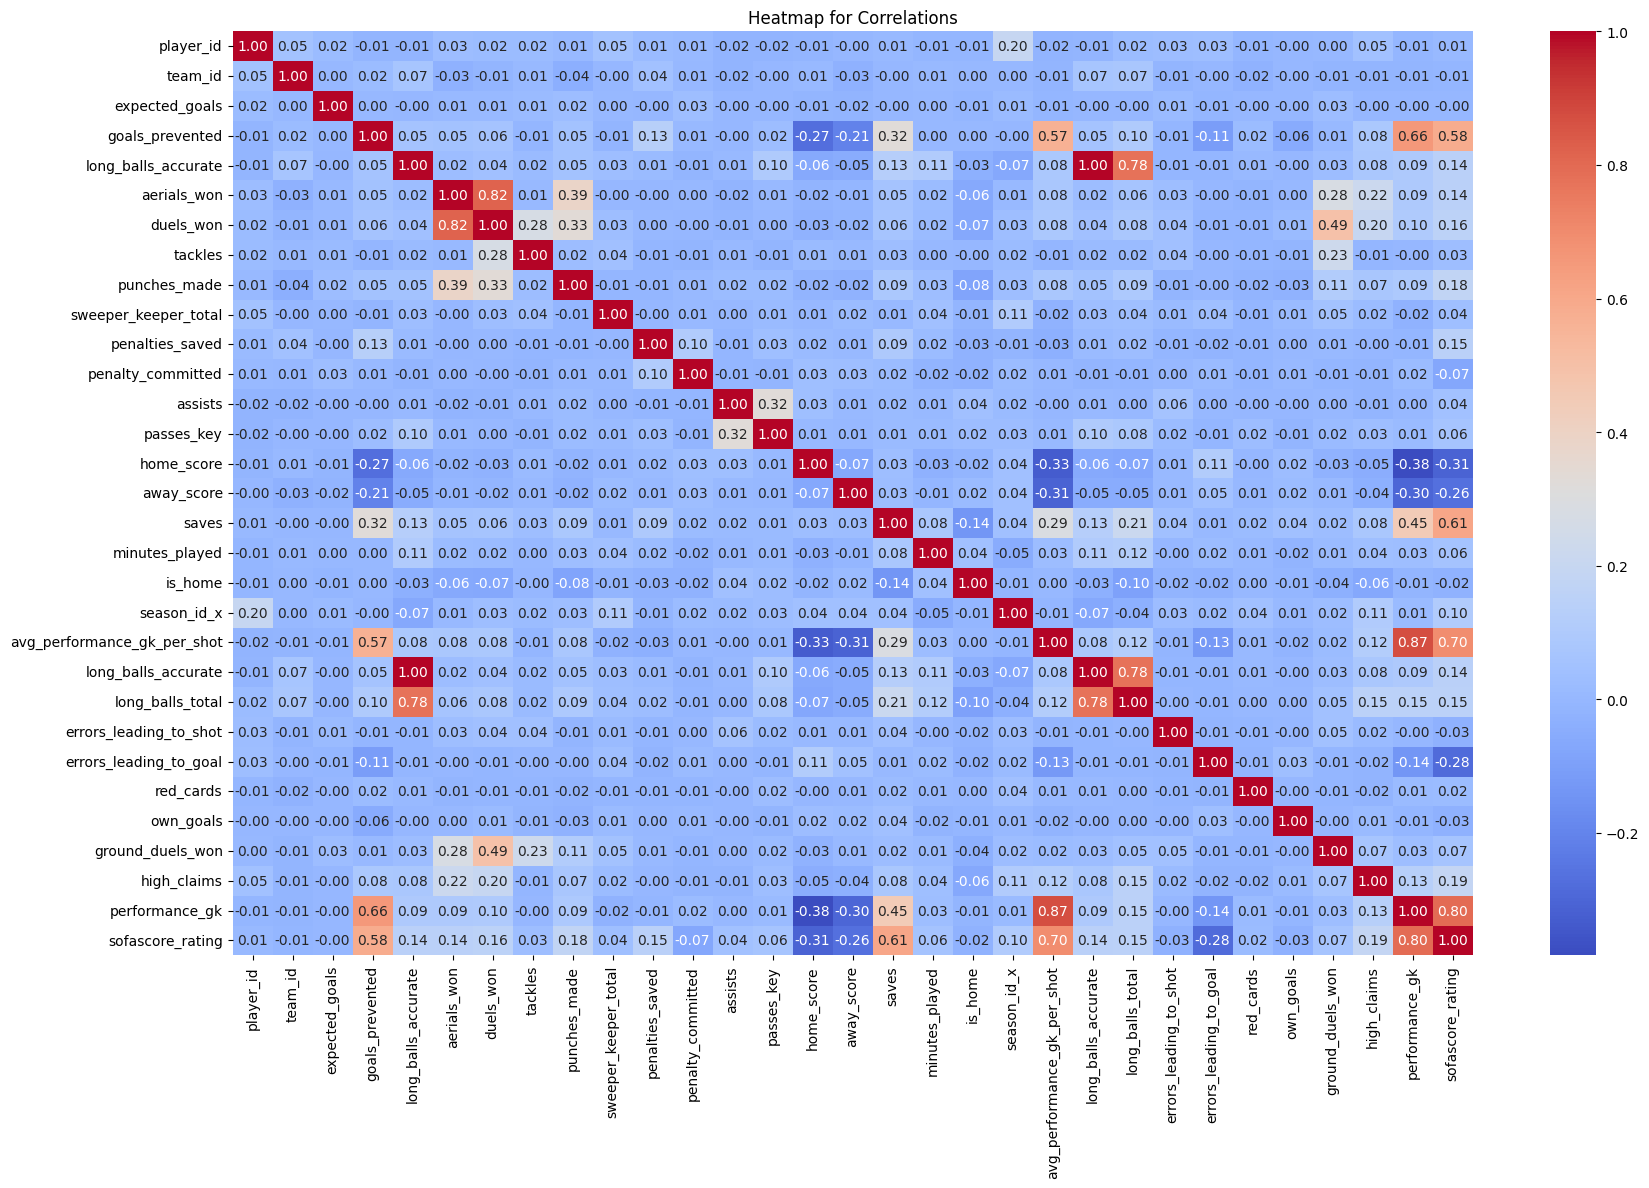

In [78]:
def heatmap(df, var_analyze):
    
    df_analyze = df[var_analyze]
    plt.figure(figsize=(20,12))
    plt.title('Heatmap for Correlations')
    sns.heatmap(df_analyze.corr(), annot=True, fmt = '2.2f', cmap='coolwarm')
    plt.show()

vars_analyze = ['player_id', 'team_id', 'expected_goals', 'goals_prevented', 'long_balls_accurate', 'aerials_won', 'duels_won', 'tackles', 'punches_made', 'sweeper_keeper_total','penalties_saved',
                    'penalty_committed', 'assists', 'passes_key', 'home_score', 'away_score', 'saves', 'minutes_played', 'is_home', 'season_id_x', 'avg_performance_gk_per_shot', 'long_balls_accurate',
                    'long_balls_total', 'errors_leading_to_shot', 'errors_leading_to_goal', 'red_cards', 'own_goals', 'ground_duels_won', 'high_claims','performance_gk', 'sofascore_rating']

heatmap(df_goalkeepers, vars_analyze)



Really good, we got a 0.8 correlation with the sofascore rating using our evaluation metric 'PERFORMANCE_GK' and we also got a 0.7 evaluation metric on avg_performance_gk_per_shots. 

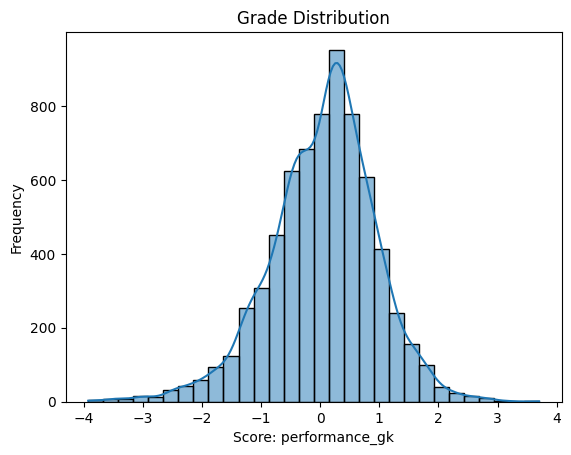

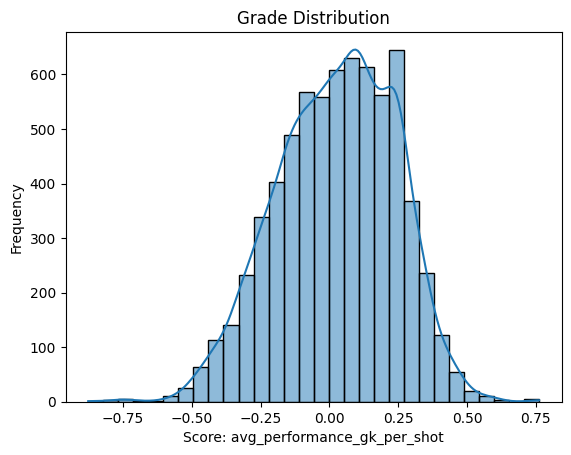

In [79]:
#df_goalkeepers_clean['performance_gk']

#gk_prior_scaling = df_goalkeepers_clean.groupby(['player_id'])['performance_gk'].mean().reset_index(name = 'performance_prior_scaling')

def hist_plot(df, col):

    sns.histplot(df[col], bins=30, kde=True)
    plt.title('Grade Distribution')
    plt.xlabel(f'Score: {col}')
    plt.ylabel('Frequency')
    plt.show()


hist_plot(df_goalkeepers, 'performance_gk')
hist_plot(df_goalkeepers, 'avg_performance_gk_per_shot')



We see that both of our metrics follows a normal like curve, but both metrics have two huge problems:

1) Both of them are not interpretable

2) They only take in consideration saves, which yes are the biggest rol of this position but theres ton of information that should be important also for this role, like: clean_sheets, penalties_saved, high_calims, etc....



# Scaling the metric to a readable value

First we will clip our scoring, the idea here is setting a max value based on the 1% scores of the distribution, the idea here is setting the max value as the 1% of the performances so more than 1 single performance can be the maximum value possible. In this case will use a 30 - 100 range value for our metric to evaluate players, using a min max alike approach.

Once our value is more interpretable we will add the other importance metrics for the performance of a goalkeeper.

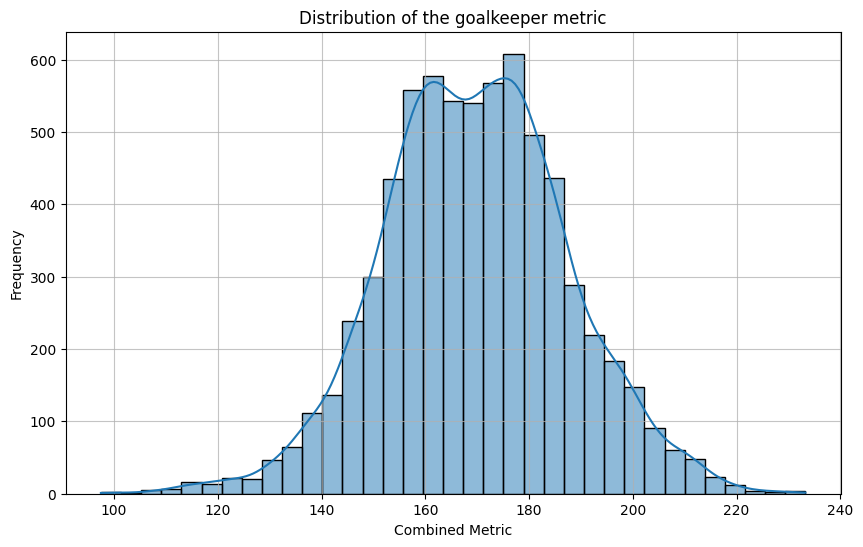

In [80]:
def performance_metric(df, main_metric_col, name_result):

    bonus_metrics_raw_counts = [
        'long_balls_accurate', 'aerials_won', 'passes_accurate'
    ]

    bonus_metrics_events = [
        'penalties_saved', 'assists', 'passes_key',
        'sweeper_keeper_total', 'punches_made', 'high_claims', 'tackles',
    ]

    penalty_metrics_events = [
        'errors_leading_to_goal', 'errors_leading_to_shot',
        'penalty_committed', 'red_cards', 'own_goals', 'yellow_cards'
    ]

    norm_df = df.copy()
    norm_df.reset_index(drop=True, inplace=True)

    norm_df['long_balls_ratio'] = np.where(norm_df['long_balls_total'] > 0,
                                           norm_df['long_balls_accurate'] / norm_df['long_balls_total'], 0)
    norm_df['aerials_duel_ratio'] = np.where((norm_df['aerials_won'] + norm_df['aerials_lost']) > 0,
                                             norm_df['aerials_won'] / (norm_df['aerials_won'] + norm_df['aerials_lost']), 0)
    norm_df['passes_ratio'] = np.where(norm_df['passes_total'] > 0,
                                       norm_df['passes_accurate'] / norm_df['passes_total'], 0)

    scaler = MinMaxScaler()

    all_metrics_to_normalize = [main_metric_col] + bonus_metrics_events + penalty_metrics_events
    
    norm_df[main_metric_col + '_norm'] = scaler.fit_transform(norm_df[[main_metric_col]])
    for col in bonus_metrics_events:
        if col in norm_df.columns:
            norm_df[col + '_norm'] = scaler.fit_transform(norm_df[[col]])
        else:
            print(f"Advertencia: Columna de bonus '{col}' no encontrada en el DataFrame.")
            norm_df[col + '_norm'] = 0

    for col in penalty_metrics_events:
        if col in norm_df.columns:
            if col == 'yellow_cards':
                temp_yellow = norm_df[col].clip(upper=2)
                norm_df[col + '_norm_raw_penalty'] = temp_yellow / 2.0
            else:
                norm_df[col + '_norm_raw_penalty'] = scaler.fit_transform(norm_df[[col]])
            norm_df[col + '_inv'] = 1 - norm_df[col + '_norm_raw_penalty']
        else:
            print(f"Advertencia: Columna de penalización '{col}' no encontrada en el DataFrame.")
            norm_df[col + '_inv'] = 1

    coefs = {
        main_metric_col + '_norm': 100.0,
        'penalties_saved_norm': 20.0,
        'assists_norm': 15.0,
        'passes_key_norm': 5.0,
        'sweeper_keeper_total_norm': 15.0,
        'punches_made_norm': 8.0,
        'high_claims_norm': 12.0,
        'tackles_norm': 3.0,
        'errors_leading_to_goal_inv': 25.0,
        'errors_leading_to_shot_inv': 10.0,
        'penalty_committed_inv': 20.0,
        'red_cards_inv': 30.0,
        'own_goals_inv': 25.0,
        'yellow_cards_inv': 10.0
    }

    norm_cols_for_weighting = [mc for mc in coefs.keys() if mc in norm_df.columns]

    norm_df[name_result] = 0.0

    for metric_col, weight in coefs.items():
        if metric_col in norm_df.columns:
            norm_df[name_result] += norm_df[metric_col] * weight
        else:
            print(f"Advertencia: La columna '{metric_col}' para ponderación no está en norm_df. No se aplicará peso.")

    long_ball_bonus_val = coefs.get('tackles_norm', 3.0)
    aerial_duel_bonus_val = coefs.get('punches_made_norm', 8.0) 
    pass_ratio_bonus_val = coefs.get('passes_key_norm', 5.0) / 2

    norm_df.loc[norm_df['long_balls_ratio'] >= 0.75, name_result] += long_ball_bonus_val
    norm_df.loc[(norm_df['long_balls_ratio'] > 0.5) & (norm_df['long_balls_ratio'] < 0.75), name_result] += long_ball_bonus_val / 2
    norm_df.loc[norm_df['long_balls_ratio'] <= 0.5, name_result] -= long_ball_bonus_val

    norm_df.loc[norm_df['aerials_duel_ratio'] >= 0.75, name_result] += aerial_duel_bonus_val
    norm_df.loc[(norm_df['aerials_duel_ratio'] > 0.4) & (norm_df['aerials_duel_ratio'] < 0.75), name_result] += aerial_duel_bonus_val / 2
    norm_df.loc[norm_df['aerials_duel_ratio'] <= 0.4, name_result] -= aerial_duel_bonus_val

    norm_df.loc[norm_df['passes_ratio'] >= 0.8, name_result] += pass_ratio_bonus_val
    norm_df.loc[norm_df['passes_ratio'] <= 0.5, name_result] -= pass_ratio_bonus_val

    clean_sheet_multiplier = 1.05
    mask_local_cs = (norm_df['is_home'] == 1) & (norm_df['away_score'] < 1)
    mask_away_cs = (norm_df['is_home'] == 0) & (norm_df['home_score'] < 1)
    
    norm_df.loc[mask_local_cs, name_result] *= clean_sheet_multiplier
    norm_df.loc[mask_away_cs, name_result] *= clean_sheet_multiplier

    return norm_df


df_gk_scored = performance_metric(df_goalkeepers, 'performance_gk', 'combined_performance_score')

plt.figure(figsize=(10, 6))
sns.histplot(df_gk_scored['combined_performance_score'], kde=True, bins=35) # Ajusta bins según tu número de porteros
plt.title('Distribution of the goalkeeper metric')
plt.xlabel('Combined Metric')
plt.ylabel('Frequency')
plt.grid(alpha=0.75)
plt.show()

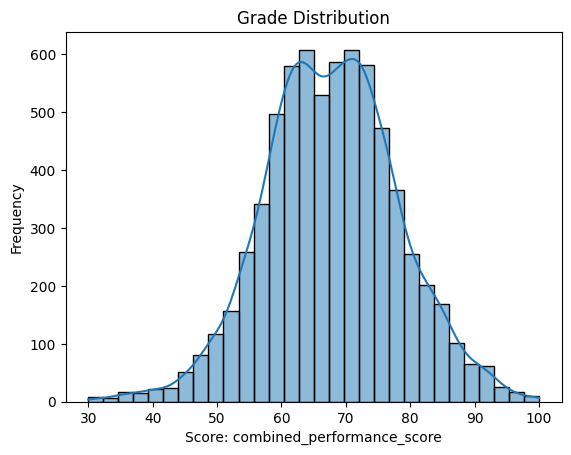

In [81]:
def scaling_metric(df, metric, low, up, plot = True):
    raw_score_min_clip = low
    raw_score_max_clip = up
    df[metric] = df[metric].clip(lower=raw_score_min_clip, upper=raw_score_max_clip)

    scale_min = 30.0
    scale_max = 100.0

    min_performance = df[metric].min()
    max_performance = df[metric].max()

    df[metric] = scale_min + (df[metric] - min_performance) * (scale_max - scale_min) / (max_performance - min_performance)

    df[metric] = df[metric].clip(scale_min, scale_max)

    if plot:
        hist_plot(df, metric) 
    
    return df

df_gk_scored_scaled = scaling_metric(df_gk_scored, 'combined_performance_score', low=105, up=225, plot = True)

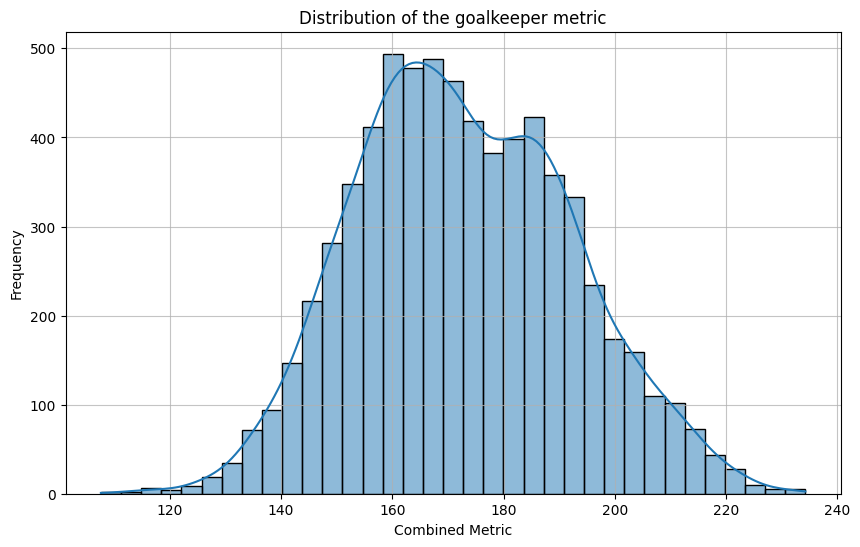

In [82]:
df_gk_scored_scaled2 = performance_metric(df_gk_scored_scaled, 'avg_performance_gk_per_shot', 'avg_performance_gk_per_shot_score')
plt.figure(figsize=(10, 6))
sns.histplot(df_gk_scored_scaled2['avg_performance_gk_per_shot_score'], kde=True, bins=35) 
plt.title('Distribution of the goalkeeper metric')
plt.xlabel('Combined Metric')
plt.ylabel('Frequency')
plt.grid(alpha=0.75)
plt.show()

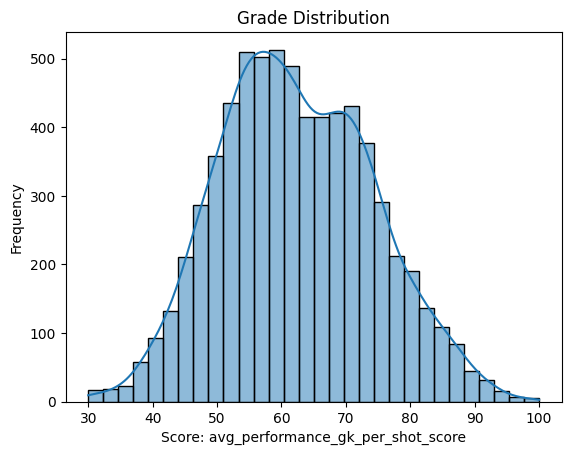

In [83]:
df_gk_scored_scaled_full = scaling_metric(df_gk_scored_scaled2, 'avg_performance_gk_per_shot_score', low=120, up=235, plot = True)

Now we will only use one performance metric to evaluate the goalkeeper. The idea will be to use the higher value for gk_performance_scaled or avg_performance_gk_per_shot_scaled, remembering avg_performance_gk_per_shot_scaled is just a helper for special cases like goalkeepers in dominant teams.

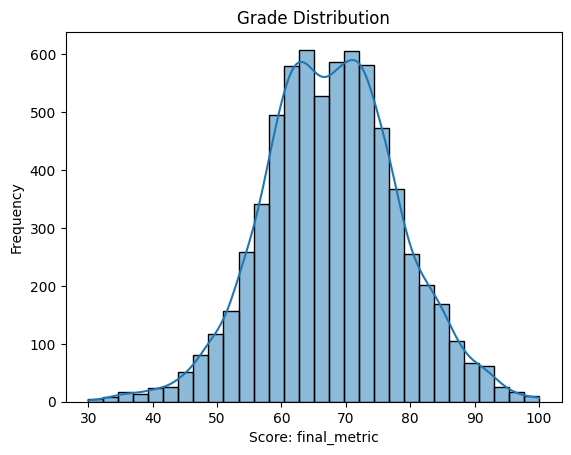

In [84]:
def selecting_final_score(df):
    df1 = df.copy()
    # Seleccionar el máximo entre las dos métricas
    df1['final_metric'] = np.where(
        df1['avg_performance_gk_per_shot_score'] - (df1['avg_performance_gk_per_shot_score'] * 0.1) >= df1['combined_performance_score'], 
       df1['avg_performance_gk_per_shot_score'] - (df1['avg_performance_gk_per_shot_score'] * 0.1), #else
        df1['combined_performance_score']
    )
    return df1


df_goalkeepers_full = selecting_final_score(df_gk_scored_scaled_full)
hist_plot(df_goalkeepers_full, 'final_metric')


# Who are the best goalkeepers according to our metrics?

here i defined a constant to allow performing a groupby overall and a groupby per season for the means of a goalkeeper in our performance measure, use 1 for overall best gk and 0 for gk performance per season.

,player_id,count_matches_per_season,mean_performance_per_season,players_name
15,128383,44,71.9916,Gerónimo Rulli
16,254491,131,71.6378,Ederson
17,243609,145,71.4907,Alisson
18,70988,120,71.3417,Thibaut Courtois
20,232422,73,70.8635,Kepa Arrizabalaga
21,88625,126,70.8488,Marc-André ter Stegen
26,581310,110,69.5500,David Raya
27,553606,57,69.3244,Guglielmo Vicario
28,920546,119,69.2397,Robert Sánchez
29,791773,157,69.1997,Álex Remiro


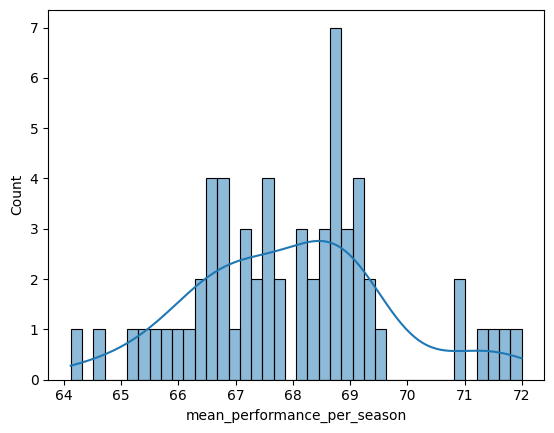

In [106]:
OVERALL_KEEPERS = 1

if not OVERALL_KEEPERS:
    performance_per_season = df_goalkeepers_full.groupby(['player_id', 'season_id_x']).agg(
        count_matches_per_season=('final_metric', 'count'),
        mean_performance_per_season=('final_metric', 'mean')
    ).reset_index()

    players_performance = performance_per_season.merge(
        players[['player_id', 'name']],
        on='player_id',
        how='left'
    )

    order_performance = players_performance.sort_values(
        by=['mean_performance_per_season'],
        ascending=False
    ).reset_index(drop=True)

    order_performance = order_performance.rename(columns = {'season_id_x': 'season_id', 'name': 'players_name'})
    order_performance_season = order_performance.merge(seasons[['season_id', 'name']], how = 'left', on='season_id')

    min_matches = 19


else:
    performance_per_season = df_goalkeepers_full.groupby(['player_id']).agg(
        count_matches_per_season=('final_metric', 'count'),
        mean_performance_per_season=('final_metric', 'mean')
    ).reset_index()

    players_performance = performance_per_season.merge(
        players[['player_id', 'name']],
        on='player_id',
        how='left'
    )

    order_performance = players_performance.sort_values(
        by=['mean_performance_per_season'],
        ascending=False
    ).reset_index(drop=True)

    min_matches = 38

    order_performance = order_performance.rename(columns = {'season_id_x': 'season_id', 'name': 'players_name'})
    #order_performance_season = order_performance.merge(seasons[['season_id', 'name']], how = 'left', on='season_id')

minimum_games_filter = order_performance['count_matches_per_season'] > min_matches


order_performance = order_performance.loc[minimum_games_filter]
sns.histplot(data = order_performance, x = 'mean_performance_per_season', bins = 40, kde=True)
order_performance.head(10)




<Axes: >

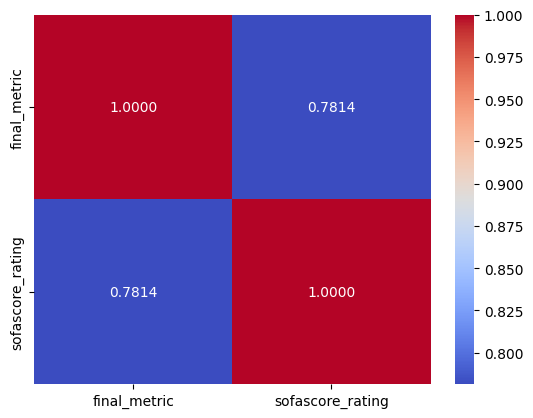

In [86]:
a = df_goalkeepers_full[['final_metric', 'sofascore_rating']]
sns.heatmap(a.corr(), annot = True, fmt = '4.4f', cmap = 'coolwarm')

#a[['final_metric', 'sofascore_rating']].sort_values(by = 'sofascore_rating', ascending = False).head(25)

# Almost done, but now we need to take care of cases 2 & 3

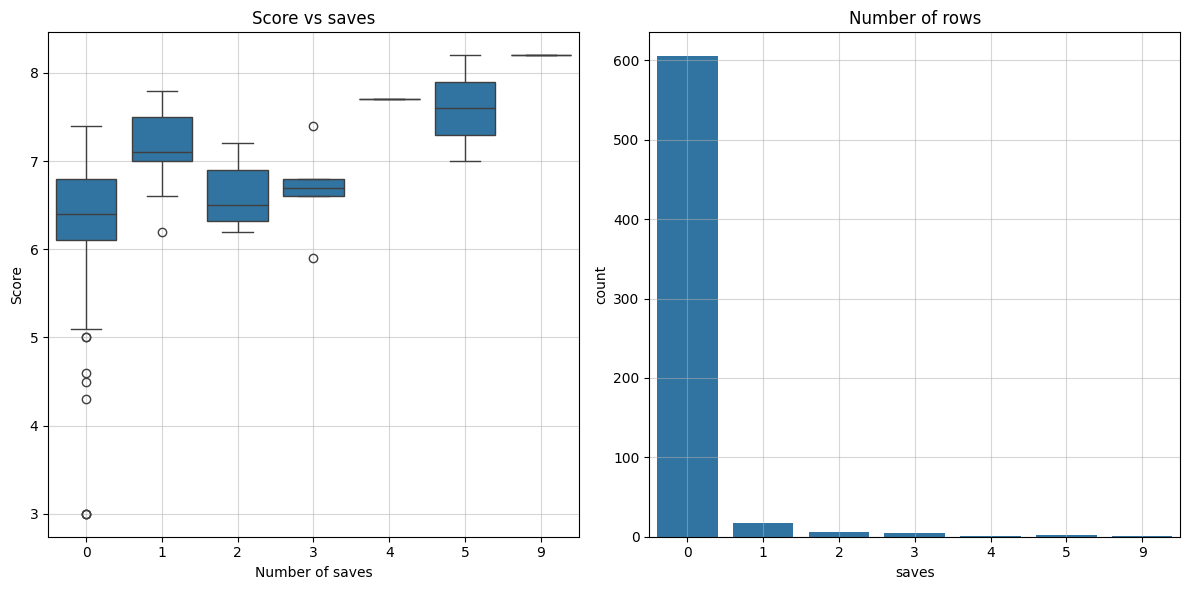

In [87]:
def visualizations(df):
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    sns.boxplot(data = df, x = 'saves', y='sofascore_rating', ax = axes[0])
    axes[0].set_title('Score vs saves')
    axes[0].set_xlabel('Number of saves')
    axes[0].set_ylabel('Score')
    axes[0].grid(alpha = 0.5)
    sns.countplot(data = df, x = 'saves')
    axes[1].set_title('Number of rows')

    plt.tight_layout()
    plt.grid(alpha = 0.5)
    plt.show()


visualizations(df_gk_no_saves)


So theres two or more poblations in this subset of goalkeepers:

1) Those gk with saves: How your getting NaN on performance_gk while getting up to 9 saves? The answer is: YOU DONT HAVE THE DATA OF THE SHOTS IN THAT MATCH...

2) Goalkeepers with 0 saves because their team was so dominant the other team wasnt able to shot on target.

3) The second scenario or simply a bad or unfortunate day where he wasnt able to catch a single shot but we can determine if this was the case with ease because this rows will have a performance_gk different of NaN.



# Case 2:
When we have the number of saves but not the shots stats, we will take the average of gk_performance for each goalkeeper for each number of saves and join it with the missing value.

In [88]:
avg_per_save = df_goalkeepers_full.groupby(['player_id', 'saves']).agg(
    mean_performance_per_n_saves = ('final_metric', 'mean')
).reset_index()

no_saves_only = df_gk_no_saves['saves'] == 0
gk_missing_shot_info = df_gk_no_saves.loc[~no_saves_only]
gk_missing_shot_info = gk_missing_shot_info.merge(avg_per_save[['player_id', 'saves', 'mean_performance_per_n_saves']], how = 'left', on = ['player_id', 'saves'])
gk_missing_shot_info[['saves', 'sofascore_rating', 'mean_performance_per_n_saves']].head(10)

,saves,sofascore_rating,mean_performance_per_n_saves
0,1,7.4000,62.6520
1,1,7.6000,61.6587
2,1,7.8000,64.0295
3,1,7.5000,64.5298
4,3,6.6000,69.3327
5,1,7.1000,64.9837
6,3,5.9000,61.4155
7,4,7.7000,71.8952
8,1,7.0000,67.2254
9,1,7.1000,66.6739


# CASES where team was just super dominant

first we will check if the player played at least 45 minutes, if so we will create a performance based on the other metrics ignoring the importance of the main field "performance_gk". This approach will be to start with a maximum score value and just punishing small errors lowering the grade.

In [89]:
#filtering for no saves subset
df_gk_zero_saves = df_gk_no_saves.loc[no_saves_only]

#filtering for local & no goals from enemy team
df_gk_zero_saves_local = df_gk_zero_saves.loc[df_gk_zero_saves['is_home'] == 1]
filter_no_goal_visit = df_gk_zero_saves_local['away_score'] == 0
df_gk_zero_saves_local = df_gk_zero_saves_local.loc[filter_no_goal_visit]

#Same but for visit
df_gk_zero_saves_visit = df_gk_zero_saves.loc[df_gk_zero_saves['is_home'] == 0]
filter_no_goal_home = df_gk_zero_saves_visit['home_score'] == 0
df_gk_zero_saves_visit = df_gk_zero_saves_visit.loc[filter_no_goal_home]

In [90]:
df_gk_zero_saves_local[['home_score','away_score', 'sofascore_rating', 'saves', 'performance_gk', 'is_substitute', 'minutes_played']].head(25)

,home_score,away_score,sofascore_rating,saves,performance_gk,is_substitute,minutes_played
115,1,0,6.5000,0,0.2467,1,14
205,3,0,6.6000,0,NaN,0,90
268,5,0,7.0000,0,NaN,0,90
287,3,0,6.7000,0,NaN,0,90
340,1,0,7.0000,0,NaN,0,90
392,4,0,7.0000,0,NaN,0,90
395,1,0,6.9000,0,NaN,0,90
515,1,0,6.9000,0,NaN,0,90
523,0,0,7.1000,0,NaN,0,90
568,3,0,6.7000,0,NaN,0,90


We now see a problem, substitute players with few game time as row #1, will drop him adn the others with this condition. 

In [91]:
def drop_low_activity_substitutes(df, inspect: bool):
    subs_only = (df['is_substitute'] == 1) | (df['minutes_played'] <= 45)
    not_subs = df.loc[~subs_only]
    if inspect:
        print(len(df.loc[subs_only]))
    return not_subs

df_gk_zero_saves_local = drop_low_activity_substitutes(df_gk_zero_saves_local, True)
df_gk_zero_saves_visit = drop_low_activity_substitutes(df_gk_zero_saves_visit, True)



4
2


In [92]:
df_gk_zero_saves_visit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 155 to 3713
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_match_stat_id         72 non-null     int64  
 1   match_id                     72 non-null     int64  
 2   player_id                    72 non-null     int64  
 3   team_id                      72 non-null     int64  
 4   is_substitute                72 non-null     int64  
 5   played_position              72 non-null     object 
 6   jersey_number                72 non-null     int64  
 7   market_value_eur_at_match    72 non-null     float64
 8   sofascore_rating             72 non-null     float64
 9   minutes_played               72 non-null     int64  
 10  touches                      72 non-null     int64  
 11  goals                        72 non-null     int64  
 12  assists                      72 non-null     int64  
 13  own_goals              

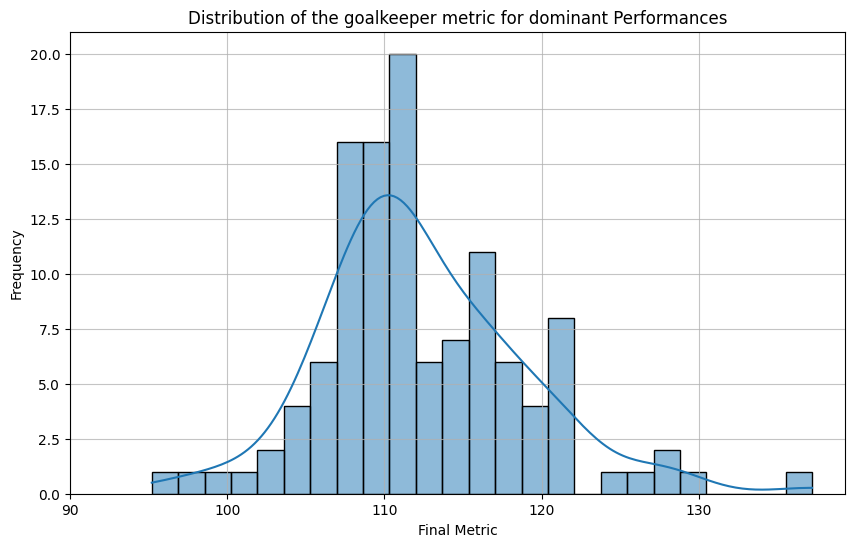

In [93]:
def performance_metric_no_shots_faced(df, name_result, main_metric_col_name_placeholder='performance_gk'):
    bonus_metrics_raw_counts = [
        'long_balls_accurate', 'aerials_won', 'passes_accurate'
    ]

    bonus_metrics_events = [
        'penalties_saved', 'assists', 'passes_key',
        'sweeper_keeper_total', 'punches_made', 'high_claims', 'tackles',
    ]

    penalty_metrics_events = [
        'errors_leading_to_goal', 'errors_leading_to_shot',
        'penalty_committed', 'red_cards', 'own_goals', 'yellow_cards'
    ]

    norm_df = df.copy()
    norm_df.reset_index(drop=True, inplace=True)

    norm_df['long_balls_ratio'] = np.where(norm_df['long_balls_total'] > 0,
                                           norm_df['long_balls_accurate'] / norm_df['long_balls_total'], 0)
    norm_df['aerials_duel_ratio'] = np.where((norm_df['aerials_won'] + norm_df['aerials_lost']) > 0,
                                             norm_df['aerials_won'] / (norm_df['aerials_won'] + norm_df['aerials_lost']), 0)
    norm_df['passes_ratio'] = np.where(norm_df['passes_total'] > 0,
                                       norm_df['passes_accurate'] / norm_df['passes_total'], 0)

    scaler = MinMaxScaler()

    for col in bonus_metrics_events:
        if col in norm_df.columns:
            norm_df[col + '_norm'] = scaler.fit_transform(norm_df[[col]])
        else:
            print(f"Advertencia: Columna de bonus '{col}' no encontrada en el DataFrame.")
            norm_df[col + '_norm'] = 0

    for col in penalty_metrics_events:
        if col in norm_df.columns:
            if col == 'yellow_cards':
                temp_yellow = norm_df[col].clip(upper=2)
                norm_df[col + '_norm_raw_penalty'] = temp_yellow / 2.0
            else:
                norm_df[col + '_norm_raw_penalty'] = scaler.fit_transform(norm_df[[col]])
            norm_df[col + '_inv'] = 1 - norm_df[col + '_norm_raw_penalty']
        else:
            print(f"Advertencia: Columna de penalización '{col}' no encontrada en el DataFrame.")
            norm_df[col + '_inv'] = 1

    coefs = {
        'penalties_saved_norm': 20.0,
        'assists_norm': 15.0,
        'passes_key_norm': 5.0,
        'sweeper_keeper_total_norm': 3.5,
        'punches_made_norm': 5,
        'high_claims_norm': 5,
        'tackles_norm': 3.0,
        'errors_leading_to_goal_inv': 25.0,
        'errors_leading_to_shot_inv': 10.0,
        'penalty_committed_inv': 20.0,
        'red_cards_inv': 30.0,
        'own_goals_inv': 15.0,
        'yellow_cards_inv': 10.0
    }

    norm_df[name_result] = 0.0

    for metric_col_key, weight in coefs.items():
        if metric_col_key in norm_df.columns:
            norm_df[name_result] += norm_df[metric_col_key] * weight
        else:
            print(f"Advertencia: La columna '{metric_col_key}' para ponderación no está en norm_df. No se aplicará peso.")

    long_ball_bonus_val = coefs.get('tackles_norm', 3.0)
    aerial_duel_bonus_val = coefs.get('punches_made_norm', 8.0)
    pass_ratio_bonus_val = coefs.get('passes_key_norm', 5.0) / 2

    norm_df.loc[norm_df['long_balls_ratio'] >= 0.75, name_result] += long_ball_bonus_val
    norm_df.loc[(norm_df['long_balls_ratio'] > 0.5) & (norm_df['long_balls_ratio'] < 0.75), name_result] += long_ball_bonus_val / 2
    norm_df.loc[norm_df['long_balls_ratio'] <= 0.5, name_result] -= long_ball_bonus_val

    norm_df.loc[norm_df['aerials_duel_ratio'] >= 0.75, name_result] += aerial_duel_bonus_val
    norm_df.loc[(norm_df['aerials_duel_ratio'] > 0.4) & (norm_df['aerials_duel_ratio'] < 0.75), name_result] += aerial_duel_bonus_val / 2
    norm_df.loc[norm_df['aerials_duel_ratio'] <= 0.4, name_result] -= aerial_duel_bonus_val

    norm_df.loc[norm_df['passes_ratio'] >= 0.8, name_result] += pass_ratio_bonus_val
    norm_df.loc[norm_df['passes_ratio'] <= 0.5, name_result] -= pass_ratio_bonus_val

    clean_sheet_multiplier = 1.05
    mask_local_cs = (norm_df['is_home'] == 1) & (norm_df['away_score'] < 1)
    mask_away_cs = (norm_df['is_home'] == 0) & (norm_df['home_score'] < 1)

    norm_df.loc[mask_local_cs, name_result] *= clean_sheet_multiplier
    norm_df.loc[mask_away_cs, name_result] *= clean_sheet_multiplier

    return norm_df



df_gk_zero_saves_local_metric = performance_metric_no_shots_faced(df_gk_zero_saves_local, 'final_metric', 'performance_gk')

plt.figure(figsize=(10, 6))
sns.histplot(df_gk_zero_saves_local_metric['final_metric'], kde=True, bins=25) 
plt.title('Distribution of the goalkeeper metric for dominant Performances')
plt.xlabel('Final Metric')
plt.xticks(range(90, 140, 10))
plt.ylabel('Frequency')
plt.grid(alpha=0.75)
plt.show()



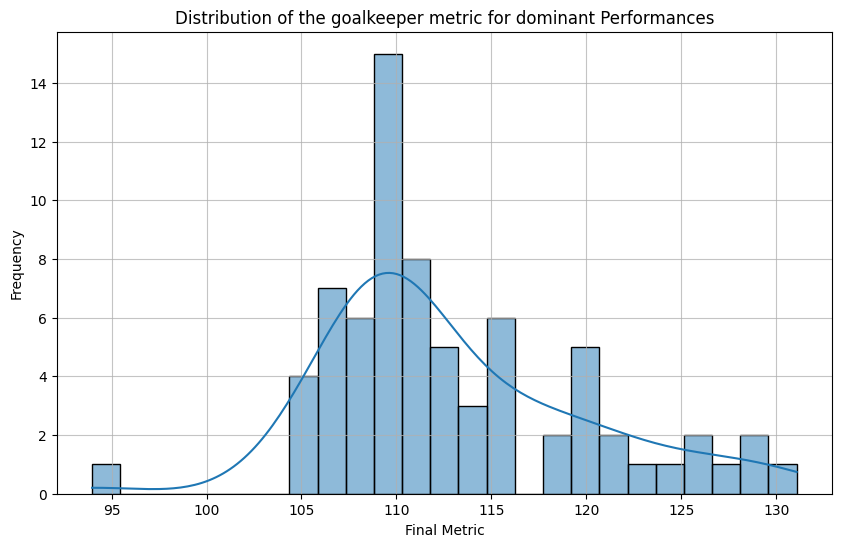

In [94]:
df_gk_zero_saves_visit_metric = performance_metric_no_shots_faced(df_gk_zero_saves_visit, 'final_metric', 'performance_gk')
plt.figure(figsize=(10, 6))
sns.histplot(df_gk_zero_saves_visit_metric['final_metric'], kde=True, bins=25) # Ajusta bins según tu número de porteros
plt.title('Distribution of the goalkeeper metric for dominant Performances')
plt.xlabel('Final Metric')
plt.ylabel('Frequency')
plt.grid(alpha=0.75)
plt.show()


In [95]:
df_gk_null_and_dominants = pd.concat([gk_missing_shot_info, df_gk_zero_saves_visit_metric, df_gk_zero_saves_local_metric], axis = 0)

To finish these model a pipeline needs to be made with all the processes done to process the data on a single step. Once all the positions metrics are done well come back and implement it.


In [96]:
df_goalkeepers_completed = pd.concat([df_gk_null_and_dominants, df_goalkeepers_full], axis = 0)

# Defense Performances
We will prioritize the key things a defendor should do which are the following:

Winning aerial duels, making key passes (ability to do fast counter - attacks), accurate passes, ground duels won (ratio), shots blocked, long_balls_ratio, goals, assists, errors_leading_to_goal, errors_leading_to_shot, enemy offsides?,dispossessed, penalties_committed, yellow_cards, red_cards,
fouls, own_goals, enemy_goals.


In [97]:
defenders = player_stats.loc[player_stats['played_position'] == 'D']
mask = defenders['sofascore_rating'].isna()
defenders_cleaned = defenders.loc[~mask]
print(len(defenders))
defenders_filled = defenders_cleaned.fillna(0)
defenders_filled.info()

50547
<class 'pandas.core.frame.DataFrame'>
Index: 34481 entries, 1 to 154268
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_match_stat_id       34481 non-null  int64  
 1   match_id                   34481 non-null  int64  
 2   player_id                  34481 non-null  int64  
 3   team_id                    34481 non-null  int64  
 4   is_substitute              34481 non-null  object 
 5   played_position            34481 non-null  object 
 6   jersey_number              34481 non-null  int64  
 7   market_value_eur_at_match  34481 non-null  float64
 8   sofascore_rating           34481 non-null  float64
 9   minutes_played             34481 non-null  int64  
 10  touches                    34481 non-null  int64  
 11  goals                      34481 non-null  int64  
 12  assists                    34481 non-null  int64  
 13  own_goals                  34481 non-null  i

In [98]:
match_stats_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7378 entries, 0 to 22129
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   team_match_stat_id           7378 non-null   int64  
 1   match_id                     7378 non-null   int64  
 2   team_id                      7378 non-null   int64  
 3   opp_team_id                  7378 non-null   int64  
 4   home_away                    7378 non-null   object 
 5   period                       7378 non-null   object 
 6   formation                    7376 non-null   object 
 7   average_team_rating          7376 non-null   float64
 8   total_team_market_value_eur  7376 non-null   float64
 9   possession_percentage        7378 non-null   float64
 10  big_chances                  7378 non-null   int64  
 11  total_shots                  7378 non-null   int64  
 12  saves                        7378 non-null   int64  
 13  corners               

C:\Users\javie\AppData\Local\Temp\ipykernel_10560\2098656097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defender_round_local['is_home'] = 1
C:\Users\javie\AppData\Local\Temp\ipykernel_10560\2098656097.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defender_round_away['is_home'] = 0


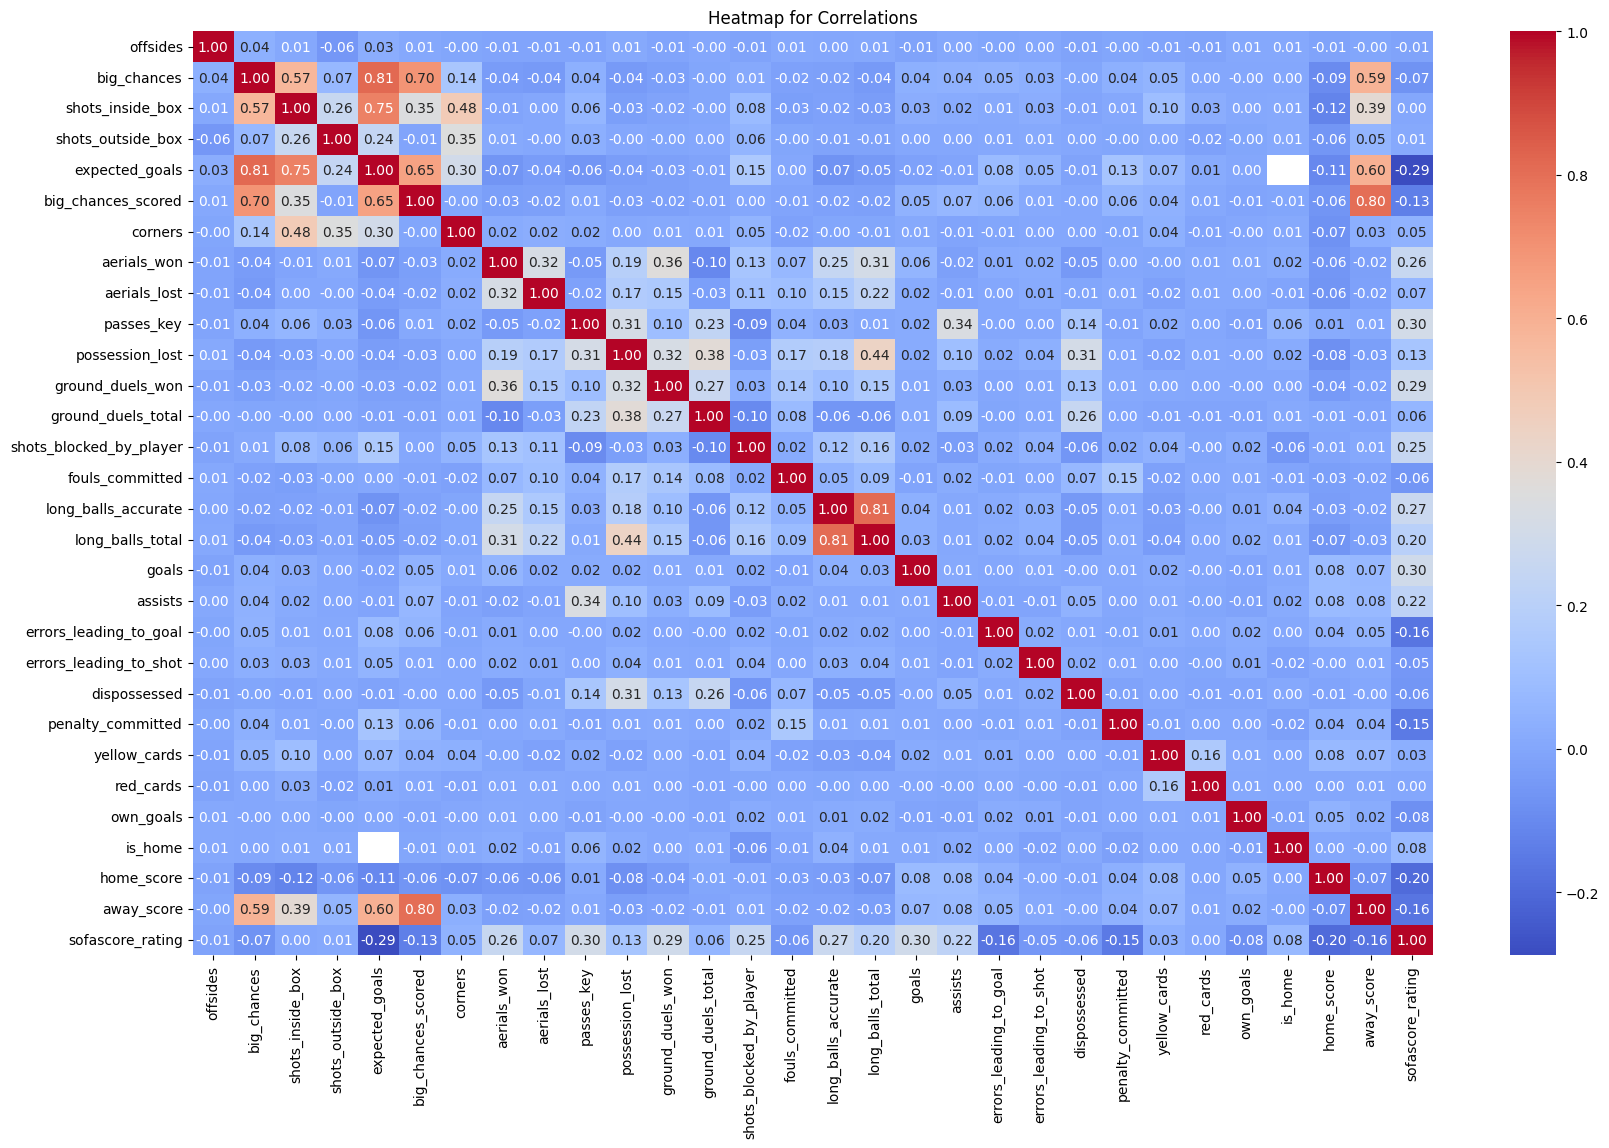

<class 'pandas.core.frame.DataFrame'>
Index: 34481 entries, 0 to 17326
Data columns (total 76 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_match_stat_id       34481 non-null  int64  
 1   match_id                   34481 non-null  int64  
 2   player_id                  34481 non-null  int64  
 3   team_id                    34481 non-null  int64  
 4   is_substitute              34481 non-null  object 
 5   played_position            34481 non-null  object 
 6   jersey_number              34481 non-null  int64  
 7   market_value_eur_at_match  34481 non-null  float64
 8   sofascore_rating           34481 non-null  float64
 9   minutes_played             34481 non-null  int64  
 10  touches                    34481 non-null  int64  
 11  goals                      34481 non-null  int64  
 12  assists                    34481 non-null  int64  
 13  own_goals                  34481 non-null  int64  


In [99]:

defenders_round = defenders_filled.merge(rounds[['away_score', 'home_score', 'match_id', 'home_team_id', 'away_team_id']], on = 'match_id', how = 'left')

mask_local = defenders_round['team_id'] == defenders_round['home_team_id']
defender_round_local = defenders_round.loc[mask_local]
defender_round_away = defenders_round.loc[~mask_local]
defender_round_local['is_home'] = 1
defender_round_away['is_home'] = 0

#Join with rival team
defender_round_local = defender_round_local.rename(columns = {'team_id': 'opp_team_id', 'expected_goals': 'xgoals_player'})

defender_round_local_stat = defender_round_local.merge(match_stats_full[['offsides', 'big_chances', 'shots_inside_box', 'shots_outside_box', 'expected_goals', 'big_chances_scored',
                                             'corners', 'match_id', 'opp_team_id']], on = ['opp_team_id', 'match_id'], how = 'left')

#Join with local team (rival)
defender_round_away_stat = defender_round_away.merge(match_stats_full[['offsides', 'big_chances', 'shots_inside_box', 'shots_outside_box', 'expected_goals', 'big_chances_scored',
                                             'corners', 'match_id', 'team_id']], on = ['team_id', 'match_id'], how = 'left')

#renaming again before concatenation
defender_round_local_stat = defender_round_local_stat.rename(columns = {'opp_team_id': 'team_id'})

defenders_round_stats = pd.concat([defender_round_local_stat, defender_round_away_stat], axis = 0)

var_defenders = ['offsides', 'big_chances', 'shots_inside_box', 'shots_outside_box', 'expected_goals', 'big_chances_scored',
                'corners', 'aerials_won', 'aerials_lost', 'passes_key', 'possession_lost', 'ground_duels_won', 'ground_duels_total', 'shots_blocked_by_player',
            'fouls_committed', 'long_balls_accurate', 'long_balls_total', 'goals', 'assists', 'errors_leading_to_goal', 'errors_leading_to_shot',
            'dispossessed', 'penalty_committed', 'yellow_cards', 'red_cards', 'own_goals', 'is_home', 'home_score', 'away_score', 'sofascore_rating']


heatmap(defenders_round_stats, var_defenders)
defenders_round_stats.info()



In [ ]:
def create_performance_defenders()

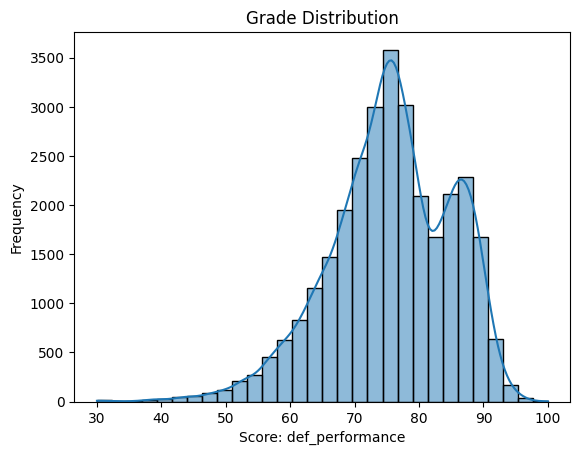

In [ ]:
def create_performance_defenders_p90(df, name_result, min_minutes_threshold=30):
    norm_df = df.copy()
    norm_df.reset_index(drop=True, inplace=True)
    not_min_threshold = norm_df['minutes_played'] > min_minutes_threshold
    norm_df = norm_df.loc[not_min_threshold]
    metrics_to_normalize_p90 = [
        'tackles', 'interceptions', 'clearances', 'shots_blocked_by_player',
        'duels_won', 'aerials_won', 'ground_duels_won', 'fouls_suffered',
        'goals', 'assists', 'passes_key', 'big_chances_created', 'penalty_won', 'offsides',
        'own_goals', 'errors_leading_to_goal', 'errors_leading_to_shot',
        'penalty_committed', 'dribbled_past', 'fouls_committed',
        'possession_lost', 'dispossessed', 'big_chances_scored', 'total_shots'
    ]
    for col in metrics_to_normalize_p90:
        if col in norm_df.columns:
            norm_df[col + '_p90'] = np.where(
                norm_df['minutes_played'] >= min_minutes_threshold,
                (norm_df[col] / norm_df['minutes_played']) * 90,
                0
            )
        else:
            norm_df[col + '_p90'] = 0
    bonus_metrics_p90_keys = [m + '_p90' for m in [
        'tackles', 'interceptions', 'clearances', 'shots_blocked_by_player',
        'duels_won', 'aerials_won', 'ground_duels_won', 'fouls_suffered',
        'goals', 'assists', 'passes_key', 'penalty_won', 'offsides'
    ]]
    penalty_metrics_p90_keys = [m + '_p90' for m in [
        'own_goals', 'errors_leading_to_goal', 'errors_leading_to_shot',
        'penalty_committed', 'fouls_committed',
        'possession_lost', 'dispossessed', 'big_chances_scored', 'total_shots'
    ]]
    penalty_metrics_cards = ['yellow_cards', 'red_cards']
    norm_df['aerial_won_ratio'] = np.where(norm_df['aerials_won'] + norm_df['aerials_lost'] > 0,
                                        norm_df['aerials_won'] / (norm_df['aerials_won'] + norm_df['aerials_lost']), 0)
    
    norm_df['duels_won_ratio'] = np.where(norm_df['duels_won'] + norm_df['duels_lost'] > 0,
                                          norm_df['duels_won'] / (norm_df['duels_won'] + norm_df['duels_lost']), 0)
    
    
    norm_df['passes_ratio'] = np.where(norm_df['passes_total'] > 0,
                                       norm_df['passes_accurate'] / norm_df['passes_total'], 0)
    norm_df['long_balls_ratio'] = np.where(norm_df['long_balls_total'] > 0,
                                           norm_df['long_balls_accurate'] / norm_df['long_balls_total'], 0)
    norm_df['crosses_ratio'] = np.where(norm_df['crosses_total'] > 0,
                                        norm_df['crosses_accurate'] / norm_df['crosses_total'], 0)
    scaler = MinMaxScaler()
    for col_p90 in bonus_metrics_p90_keys:
        if col_p90 in norm_df.columns and norm_df[col_p90].notna().any() and norm_df[col_p90].nunique() > 1:
            norm_df[col_p90 + '_norm'] = scaler.fit_transform(norm_df[[col_p90]])
        elif col_p90 in norm_df.columns and norm_df[col_p90].nunique() == 1:
             norm_df[col_p90 + '_norm'] = 0.5
        else:
            norm_df[col_p90 + '_norm'] = 0
    for col_p90 in penalty_metrics_p90_keys:
        if col_p90 in norm_df.columns and norm_df[col_p90].notna().any() and norm_df[col_p90].nunique() > 1:
            norm_df[col_p90 + '_norm_raw_penalty'] = scaler.fit_transform(norm_df[[col_p90]])
            norm_df[col_p90 + '_inv'] = 1 - norm_df[col_p90 + '_norm_raw_penalty']
        elif col_p90 in norm_df.columns and norm_df[col_p90].nunique() == 1:
            if norm_df[col_p90].iloc[0] == 0:
                 norm_df[col_p90 + '_inv'] = 1.0
            else:
                 norm_df[col_p90 + '_inv'] = 0.5
        else:
            norm_df[col_p90 + '_inv'] = 1
    for col_card in penalty_metrics_cards:
        if col_card in norm_df.columns:
            if col_card == 'yellow_cards':
                temp_yellow = norm_df[col_card].clip(upper=2)
                norm_df[col_card + '_norm_raw_penalty'] = temp_yellow / 2.0
            elif col_card == 'red_cards':
                norm_df[col_card + '_norm_raw_penalty'] = norm_df[col_card].clip(upper=1)
            norm_df[col_card + '_inv'] = 1 - norm_df[col_card + '_norm_raw_penalty']
        else:
            norm_df[col_card + '_inv'] = 1
    coefs = {
        'tackles_p90_norm': 3.5,
        'interceptions_p90_norm': 5.0,
        'clearances_p90_norm': 1.0,
        'shots_blocked_by_player_p90_norm': 10.0,
        'duels_won_p90_norm': 6.0,
        'aerials_won_p90_norm': 4.0,
        'ground_duels_won_p90_norm': 4.0,
        'goals_p90_norm': 20.0,
        'assists_p90_norm': 15.0,
        'passes_key_p90_norm': 8.0,
        'offsides_p90_norm': 5.0,
        'big_chances_created_p90_norm': 12.0,
        'penalty_won_p90_norm': 15.0,
        'fouls_suffered_p90_norm': 2.0,
        'errors_leading_to_goal_p90_inv': 25.0,
        'own_goals_p90_inv': 20.0,
        'penalty_committed_p90_inv': 25.0,
        'errors_leading_to_shot_p90_inv': 10.0,
        'fouls_committed_p90_inv': 1.5,
        'possession_lost_p90_inv': 3.0,
        'dispossessed_p90_inv': 3.0,
        'red_cards_inv': 25.0,
        'yellow_cards_inv': 10.0,
        'total_shots_p90_inv': 3.0
    }
    if 'dribbled_past_p90_inv' not in coefs and 'dribbled_past_p90' in penalty_metrics_p90_keys:
        coefs['dribbled_past_p90_inv'] = 5.0
    norm_df[name_result] = 0.0
    for metric_col_key, weight in coefs.items():
        if metric_col_key in norm_df.columns:
            norm_df[name_result] += norm_df[metric_col_key].fillna(0) * weight
    pass_ratio_bonus_val = coefs.get('passes_key_p90_norm', 2.0) * 0.5
    long_ball_bonus_val = coefs.get('clearances_p90_norm', 1.0) * 0.2
    cross_ratio_bonus_val = coefs.get('assists_p90_norm', 5.0) * 0.2
    if 'passes_ratio' in norm_df.columns:
        norm_df.loc[norm_df['passes_ratio'] >= 0.90, name_result] += pass_ratio_bonus_val
        norm_df.loc[norm_df['passes_ratio'] <= 0.70, name_result] -= pass_ratio_bonus_val
    if 'long_balls_ratio' in norm_df.columns:
        norm_df.loc[norm_df['long_balls_ratio'] >= 0.65, name_result] += long_ball_bonus_val
    if 'crosses_total' in norm_df.columns and 'crosses_ratio' in norm_df.columns:
        attempted_crosses_mask = norm_df['crosses_total'] > 0
        norm_df.loc[(attempted_crosses_mask) & (norm_df['crosses_ratio'] >= 0.75), name_result] += cross_ratio_bonus_val
    
    
    aerial_bonus_val = coefs.get('aerials_won_p90_norm', 4.0) * 0.35
    if 'aerial_won_ratio' in norm_df.columns:
        norm_df.loc[norm_df['aerial_won_ratio'] >= 0.65, name_result] += aerial_bonus_val
        norm_df.loc[norm_df['aerial_won_ratio'] <= 0.40, name_result] -= aerial_bonus_val * 0.5
        norm_df.loc[norm_df['aerial_won_ratio'] >= 0.75, name_result] += aerial_bonus_val * 0.5
        norm_df.loc[norm_df['aerial_won_ratio'] >= 0.85, name_result] += aerial_bonus_val * 0.5 
    

    duels_bonus_val = coefs.get('duels_won_p90_norm', 6.0) * 0.30
    if 'duels_won_ratio' in norm_df.columns:
        norm_df.loc[norm_df['duels_won_ratio'] >= 0.60, name_result] += duels_bonus_val
        norm_df.loc[norm_df['duels_won_ratio'] <= 0.35, name_result] -= duels_bonus_val * 0.5
        norm_df.loc[norm_df['duels_won_ratio'] >= 0.70, name_result] += duels_bonus_val * 0.5
    
    clean_sheet_multiplier = 1.05
    if all(col in norm_df.columns for col in ['team_id', 'home_team_id', 'away_score']):
        mask_local_cs = (norm_df['team_id'] == norm_df['home_team_id']) & (norm_df['away_score'] < 1)
        norm_df.loc[mask_local_cs, name_result] *= clean_sheet_multiplier
    if all(col in norm_df.columns for col in ['team_id', 'away_team_id', 'home_score']):
        mask_away_cs = (norm_df['team_id'] == norm_df['away_team_id']) & (norm_df['home_score'] < 1)
        norm_df.loc[mask_away_cs, name_result] *= clean_sheet_multiplier
    penalty_per_goal_conceded = 10
    if all(col in norm_df.columns for col in ['is_home', 'away_score']):
        mask_local_conceded_goals = (norm_df['is_home'] == 1) & (norm_df['away_score'] > 0)
        if mask_local_conceded_goals.any():
            norm_df.loc[mask_local_conceded_goals, name_result] -= norm_df.loc[mask_local_conceded_goals, 'away_score'] * penalty_per_goal_conceded
    if all(col in norm_df.columns for col in ['is_home', 'home_score']):
        mask_away_conceded_goals = (norm_df['is_home'] == 0) & (norm_df['home_score'] > 0)
        if mask_away_conceded_goals.any():
            norm_df.loc[mask_away_conceded_goals, name_result] -= norm_df.loc[mask_away_conceded_goals, 'home_score'] * penalty_per_goal_conceded

    min_performance_clip = 40
    max_performance_clip = 165
    norm_df[name_result] = norm_df[name_result].clip(lower = min_performance_clip, upper=max_performance_clip)

    min_val_for_scaling = norm_df[name_result].min()
    max_val_for_scaling = norm_df[name_result].max()

    scale_max = 100
    scale_min = 30

    norm_df[name_result] = scale_min + (norm_df[name_result] - min_val_for_scaling) * (scale_max - scale_min) / (max_val_for_scaling - min_val_for_scaling)

    hist_plot(norm_df, name_result)

    return norm_df



defenders_performance_df = create_performance_defenders_p90(defenders_round_stats, 'def_performance', min_minutes_threshold=30)

defenders_performance_df_order = defenders_performance_df[['sofascore_rating', 'def_performance']].sort_values(by = 'sofascore_rating', ascending = True).head(25)

In [115]:
a = defenders_performance_df[['sofascore_rating', 'def_performance', 'minutes_played']].sort_values(by = 'sofascore_rating', ascending = True).head(25)

<Axes: >

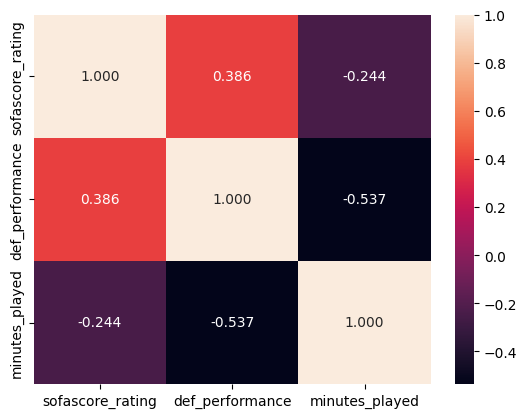

In [116]:
sns.heatmap(a.corr(), annot = True, fmt = '3.3f')